# Import libraries and define functions

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
def find_contour(ori_img, proc_img):
    temp_copy = ori_img.copy()
    
    # find contour
    contours, hierarchy = cv2.findContours(proc_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    # shortlist contours
    valid_cntrs = []

    for cntr in contours:
        x,y,w,h = cv2.boundingRect(cntr)
        area = cv2.contourArea(cntr)

        # get the bounding rect
        x, y, w, h = cv2.boundingRect(cntr)

        # get the min area rect
        rect = cv2.minAreaRect(cntr)
        box = cv2.boxPoints(rect)
        # convert all coordinates floating point values to int
        box = np.int0(box)

        if (area >= 30) & (area <= 1000):
            # valid_cntrs.append(cntr)
            valid_cntrs.append(box)
            #print("valid area is {}".format(area))
        else:
            continue
            #print("invalid area is {}".format(area))

    cv2.drawContours(temp_copy, valid_cntrs, -1, (255,0,0), 2)

    print("Number of Contours found = " + str(len(valid_cntrs))) 

    plt.figure(figsize = (10,10))
    plt.imshow(temp_copy)
    plt.show()

# Original Image

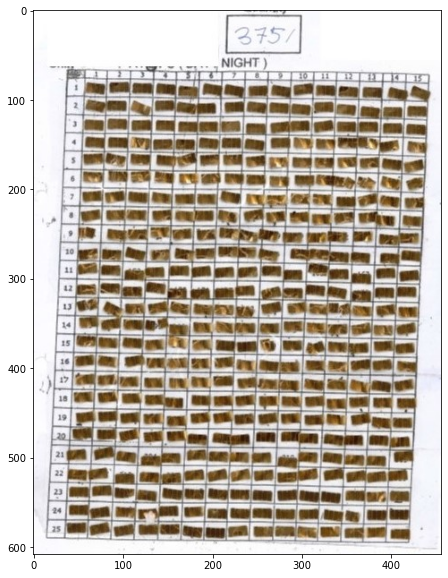

In [3]:
# Try 1053 and 1007
img = cv2.imread("dataset/train_data/train_images/1053.jpg")
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (10,10))
plt.imshow(img_RGB)

# Binary Thresholding

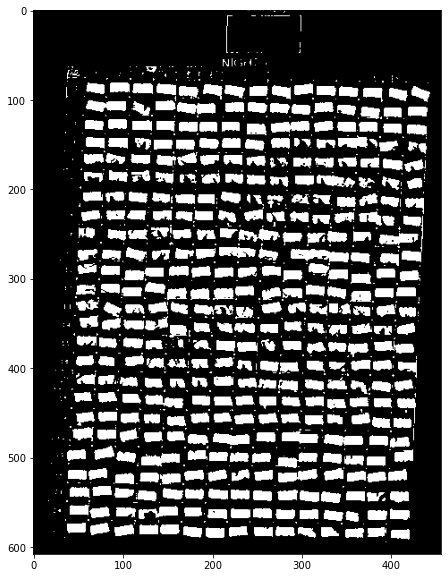

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, bin_thresh = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(10,10))
plt.imshow(bin_thresh, cmap='gray')

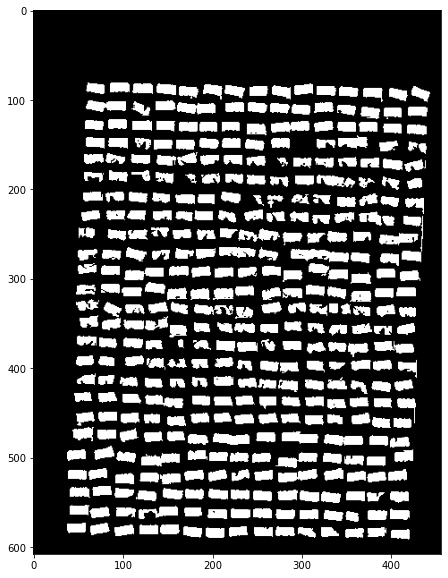

In [5]:
# Remove small specks of background noises

#find all your connected components (white blobs in your image)
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(bin_thresh, connectivity=8)
#connectedComponentswithStats yields every seperated component with information on each of them, such as size
#the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
sizes = stats[1:, -1]; nb_components = nb_components - 1

# minimum size of particles we want to keep (number of pixels)
#here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
min_size = 50  

#your answer image
img_bin = np.zeros((output.shape))
#for every component in the image, you keep it only if it's above min_size
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img_bin[output == i + 1] = 255

plt.figure(figsize=(10,10))
plt.imshow(img_bin, cmap='gray')

Number of Contours found = 355


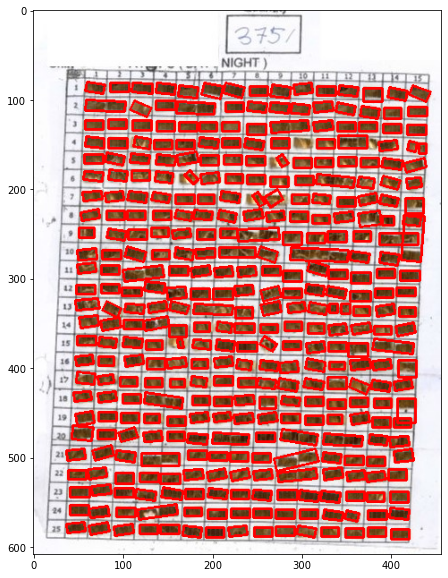

In [6]:
find_contour(img_RGB, img_bin)

# Otsu Thresholding

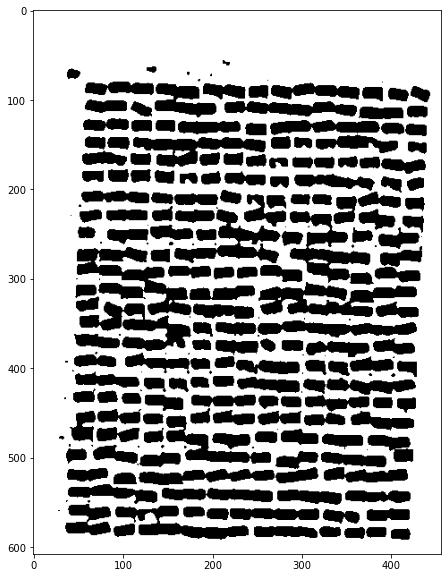

In [7]:
# ostu thresholding after Gaussian filtering
blur = cv2.GaussianBlur(gray,(9,9),0)
_, ostu_thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize = (10,10))
plt.imshow(ostu_thresh, cmap='gray')

Number of Contours found = 154


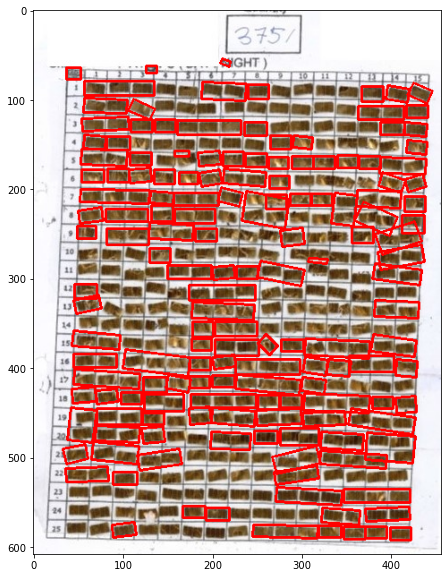

In [8]:
find_contour(img_RGB, ostu_thresh)

# Saturation
A possible implementation is to remove glare. Source code: Source code: http://www.amphident.de/en/blog/preprocessing-for-automatic-pattern-identification-in-wildlife-removing-glare.html

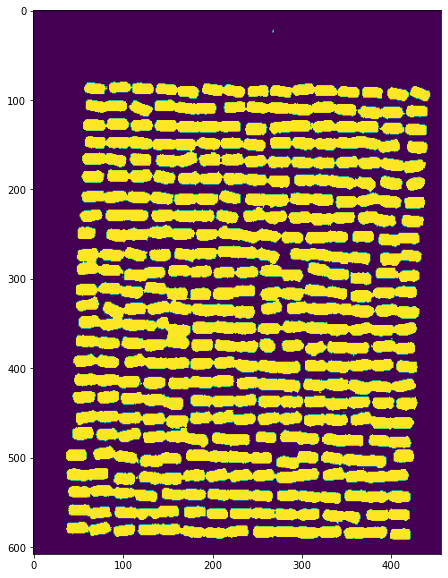

In [9]:
# Filtering saturation from original image

hsv = cv2.cvtColor(img_RGB.copy(), cv2.COLOR_BGR2HSV)

lower = np.array ([5,30,0])
upper = np.array ([120,255,255])
img_mask = cv2.inRange(hsv, lower, upper) 
img_sat = cv2.bitwise_and(img_RGB, img_RGB, mask=img_mask)

plt.figure(figsize = (10,10))
plt.imshow(img_mask)

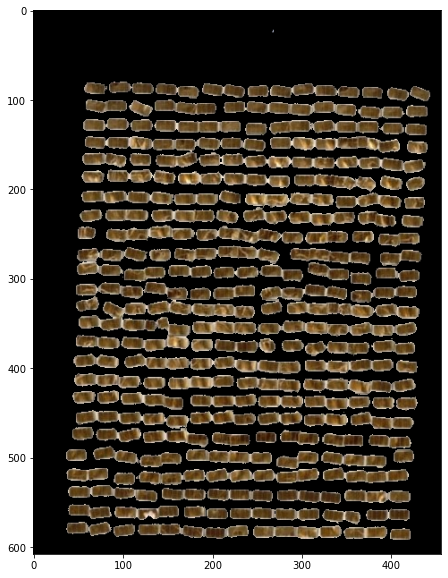

In [10]:
plt.figure(figsize = (10,10))
plt.imshow(img_sat)

Number of Contours found = 106


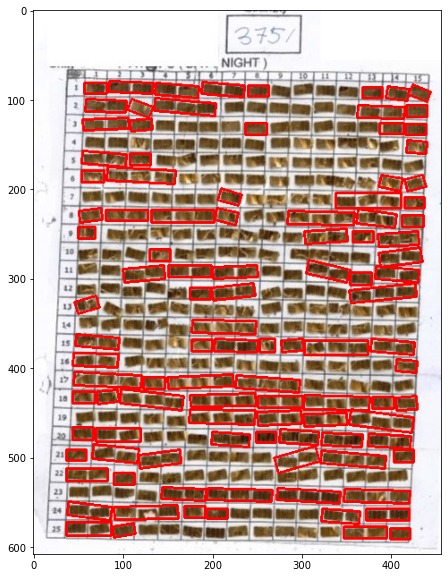

In [11]:
find_contour(img_RGB, img_mask)

# Remove shadow
Source code: https://medium.com/arnekt-ai/shadow-removal-with-open-cv-71e030eadaf5

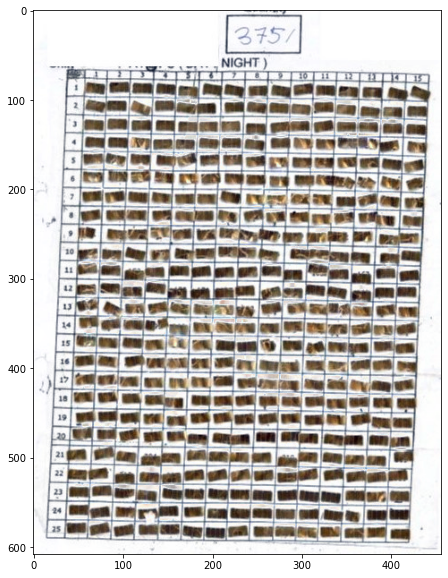

In [12]:
def shadow_remove(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((5,5), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadow_removed = cv2.merge(result_norm_planes)
    return shadow_removed

shad = shadow_remove(img_RGB)
plt.figure(figsize = (10,10))
plt.imshow(shad)